In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from reprpo.helpers.svd_decomposer import SVDDecomposer, DualSVDDecomposer, SoftSVDDecomposer, soft_svd
from reprpo.helpers.shypothesis import shypothesis

import torch
from torch import nn, Tensor
from typing import Tuple
from einops import rearrange
from jaxtyping import Float

In [1]:
import numpy as np
np.log(0.1) - np.log(0.2)

-0.6931471805599452

In [3]:
np.log(0.01) - np.log(0.2)

-2.9957322735539904

In [3]:
data = torch.load('../test/data/dual_svd_decomposer.pt')
hs_c = data['data']['chosen_hs']
hs_c = rearrange(hs_c, 'b l t h -> (b l t) h')
hs_r = data['data']['rejected_hs']
hs_r = rearrange(hs_r, 'b l t h -> (b l t) h')


WO = data['WO']
WE = data['WE']
WO.shape, hs_c.shape

FileNotFoundError: [Errno 2] No such file or directory: '../test/data/dual_svd_decomposer.pt'

In [ ]:
data['data'].keys()

dict_keys(['chosen_hs', 'rejected_hs', 'chosen_logps', 'rejected_logps', 'chosen_attn_mask', 'rejected_attn_mask', 'chosen_unemb', 'rejected_unemb', 'chosen_gthr_logps_unemb', 'rejection_gthr_logps_unemb', 'chosen_gthr_unemb', 'rejection_gthr_unemb', 'chosen_gthr_logits', 'rejected_gthr_logits', 'chosen_hs_r', 'chosen_hs_h', 'rejected_hs_r', 'rejected_hs_h'])

In [ ]:
decomposer = DualSVDDecomposer(WE, WO, full_matrices=False)

In [ ]:
decomposer.test(hs_c)

decomposer_in
Original: 12606.0390625
Output: 12606.033203125
Internal: 8.100773385422144e-08
decomposer_out
Original: 17843.53515625
Output: 17843.54296875
Internal: 9.832184133529154e-08
combined
Original: 105093616.0
Output: 105093504.0
Internal: 5.9309320931788534e-05


In [ ]:
decomposer = DualSVDDecomposer(WE, WO, full_matrices=True)
decomposer.test(hs_c)

KeyboardInterrupt: 

## d(a)-d(b) = d(a-b) ?

In [ ]:
decomposer = DualSVDDecomposer(WE, WO)

In [ ]:
hs_c_kv = hs_c-decomposer(hs_c)
hs_r_kv = hs_r-decomposer(hs_r)
d = hs_c_kv - hs_r_kv
print(torch.norm(d))

d = hs_c - hs_r
d = d-decomposer(d)
print(torch.norm(d))

tensor(0.3253)
tensor(nan)


In [ ]:
decomp = decomposer.decomposer_in

hs_c_kv = hs_c-decomp(hs_c)
hs_r_kv = hs_r-decomp(hs_r)
d = hs_c_kv - hs_r_kv
print(torch.norm(d))

d = hs_c - hs_r
d = d-decomp(d)
print(torch.norm(d))

tensor(0.3280)
tensor(0.3245)


In [ ]:
decomp = decomposer.decomposer_out

hs_c_kv = hs_c-decomp(hs_c)
hs_r_kv = hs_r-decomp(hs_r)
d = hs_c_kv - hs_r_kv
print(torch.norm(d))

d = hs_c - hs_r
d = d-decomp(d)
print(torch.norm(d))

tensor(0.2778)
tensor(0.2808)


## Soft

In [ ]:
d = SoftSVDDecomposer(WO, tau=0.5)
d.test(hs_c)

Original: 17843.53515625
Output: 39501188.0
Internal: 38470080.0


AssertionError: 

In [ ]:
U, S, Vt = torch.linalg.svd(WO, full_matrices=False)

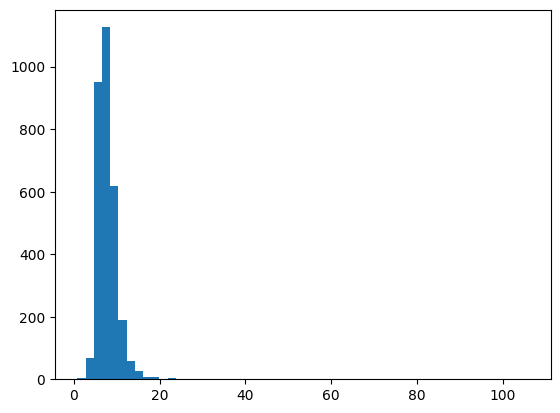

In [ ]:
from matplotlib import pyplot as plt
plt.hist(S.flatten(), bins=55);

tensor(0.1247)

In [ ]:
tau = 10
# Soft thresholding function
S_soft = torch.sign(S) * (torch.maximum(torch.abs(S) - tau, torch.zeros_like(S))+tau)


In [ ]:
torch.norm(S), torch.norm(S_soft)

(tensor(468.3420), tensor(588.5072))

In [ ]:
# before norm
torch.dist(WO, U @ torch.diag(S) @ Vt), torch.dist(WO, U @ torch.diag(S_soft) @ Vt)

(tensor(0.0014), tensor(164.6238))

In [ ]:

# Normalize to keep total "energy" constant
S_soft = S_soft * (torch.norm(S) / torch.norm(S_soft))
torch.dist(WO, U @ torch.diag(S) @ Vt), torch.dist(WO, U @ torch.diag(S_soft) @ Vt)

(tensor(0.0014), tensor(101.5163))

In [ ]:
torch.norm(S), torch.norm(S_soft)

(tensor(468.3420), tensor(468.3423))